In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

G:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
G:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
G:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
G:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

# 1.读取数据(S表示DCE-MRI数据，M表示ktrans图)
# 2.归一化(将灰度值缩放到0-1之间)
# 3.划分训练、测试集(前8000个数据增强样本作为训练集，后6个病人每个病人10个切片共60个样本作为测试集)

In [2]:
def load_data(path):
    Series = []
    Ktrans_machine = []
    patientList = range(22)                   # 22个病人
    for name in patientList:
        patient = path + "/" + str(name)      #      16-25 的切片
        for i in range(16, 26):
            qiepian = patient + "/" + str(i)
            for index in range(50):
                series = qiepian + "/series/" + str(index) + ".npy"
                series = np.load(series)
                Series.append(series)
                machine = qiepian + "/ktrans_machine/" + str(index) + ".npy"
                machine = np.load(machine)
                Ktrans_machine.append(machine)
    Series = np.array(Series)
    Ktrans_machine = np.array(Ktrans_machine)
    return Series, Ktrans_machine

S,M = load_data("./70phases_revision")
S_max,M_max = S.max(),M.max()
S,M = S/S_max,M/M_max

train_idx = []
test_idx = []
for i in range(11000):
    if (i >= 0 and i < 8000): 
        train_idx.append(i)
    elif (i % 50 == 0):
        test_idx.append(i)

x_train, y_train = S[train_idx], M[train_idx]
x_test, y_test = S[test_idx], M[test_idx]

print(x_train.shape, " ", y_train.shape, " ", x_test.shape, " ", y_test.shape)

(8000, 24, 24, 63)   (8000, 24, 24, 1)   (60, 24, 24, 63)   (60, 24, 24, 1)


#  搭建CNN模型

In [3]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape,stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1,shape=shape)
    return tf.Variable(initial)

def conv2d(x,w):
    return tf.nn.conv2d(x,w,strides=[1,1,1,1],padding='SAME')

def dilatedConv2d(input_,weights,rate):
    conv = tf.nn.atrous_conv2d(input_, weights, rate, padding='SAME')
    return conv

In [4]:
hw_size = 24
c_size = 63

with tf.name_scope("INPUT"):
    x = tf.placeholder(tf.float32,[None,hw_size,hw_size,c_size])
    y = tf.placeholder(tf.float32,[None,hw_size,hw_size,1])

with tf.name_scope("LAYER"):
    ks = 3
    w_conv1 = weight_variable([ks,ks,c_size,32])
    b_conv1 = bias_variable([32])
    h_conv1 = tf.nn.relu(conv2d(x,w_conv1)+b_conv1)
    print(h_conv1.shape)
    
    with tf.name_scope("local_path"):
        print("--LOCAL PATH--")
        w_conv2 = weight_variable([ks,ks,32,32])
        b_conv2 = bias_variable([32])
        h_conv2 = tf.nn.relu(conv2d(h_conv1,w_conv2)+ b_conv2)
        print(h_conv2.shape)

        w_conv3 = weight_variable([ks,ks,32,32])
        b_conv3 = bias_variable([32])
        h_conv3 = tf.nn.relu(conv2d(h_conv2,w_conv3)+ b_conv3)
        print(h_conv3.shape)

        w_conv4 = weight_variable([ks,ks,32,32])
        b_conv4 = bias_variable([32])
        h_conv4 = tf.nn.relu(conv2d(h_conv3,w_conv4)+ b_conv4)
        print(h_conv4.shape)
    with tf.name_scope("global_path"):
        print("--GLOBAL PATH--")
        w_conv5 = weight_variable([ks,ks,32,32])
        b_conv5 = bias_variable([32])
        h_conv5 = tf.nn.relu(dilatedConv2d(h_conv1,w_conv5,2) + b_conv5)
        print(h_conv5.shape)
        
        w_conv6 = weight_variable([ks,ks,32,32])
        b_conv6 = bias_variable([32])
        h_conv6 = tf.nn.relu(dilatedConv2d(h_conv5,w_conv6,4) + b_conv6)
        print(h_conv6.shape)
        
        w_conv7 = weight_variable([ks,ks,32,32])
        b_conv7 = bias_variable([32])
        h_conv7 = tf.nn.relu(dilatedConv2d(h_conv6,w_conv7,8) + b_conv7)
        print(h_conv7.shape)
    Connection = tf.concat([h_conv4,h_conv7],axis=-1)
    print("--Connecting--\n",Connection)

    w_fcn1 = weight_variable([1,1,64,128])
    b_fcn1 = bias_variable([128])
    h_fcn1 = tf.nn.relu(conv2d(Connection,w_fcn1)+ b_fcn1)
    print(h_fcn1.shape)
    
    w_fcn2 = weight_variable([1,1,128,64])
    b_fcn2 = bias_variable([64])
    h_fcn2 = tf.nn.relu(conv2d(h_fcn1,w_fcn2)+ b_fcn2)
    print(h_fcn2.shape)
    
    w_fcn3 = weight_variable([1,1,64,1])
    b_fcn3 = bias_variable([1])
    prediction = tf.tanh(conv2d(h_fcn2,w_fcn3)+ b_fcn3)
    print(prediction.shape)

Instructions for updating:
Colocations handled automatically by placer.
(?, 24, 24, 32)
--LOCAL PATH--
(?, 24, 24, 32)
(?, 24, 24, 32)
(?, 24, 24, 32)
--GLOBAL PATH--
(?, 24, 24, 32)
(?, 24, 24, 32)
(?, 24, 24, 32)
--Connecting--
 Tensor("LAYER/concat:0", shape=(?, 24, 24, 64), dtype=float32)
(?, 24, 24, 128)
(?, 24, 24, 64)
(?, 24, 24, 1)


# 定义损失函数、优化器、评估指标

In [5]:
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.square(y - prediction))

with tf.name_scope("train"):
    train_step = tf.train.AdamOptimizer(3e-4).minimize(loss)

with tf.name_scope("SSIM"):
    ssim = tf.image.ssim(prediction,y,max_val=1.0)
    mean_ssim = tf.reduce_mean(ssim)

with tf.name_scope("PSNR"):
    psnr = tf.image.psnr(prediction, y, max_val=1.0)
    mean_psnr = tf.reduce_mean(psnr)

with tf.name_scope("RMSE"):
    rmse = tf.sqrt(tf.reduce_mean(tf.square(y - prediction)))


# 训练10000步，每10步进行一次测试，每2000步将测试集真实样本与CNN预测图进行可视化(为了简洁起见，只可视化了前4个样本)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
test:   0  mean_psnr:  18.72529  mean_ssim:  0.15917857  RMSE:  0.11678135
测试集第0个样本：金标准:


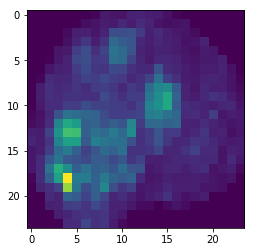

CNN预测图：


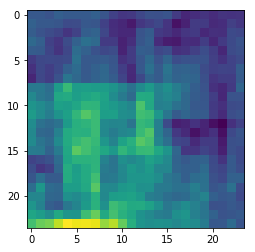

测试集第1个样本：金标准:


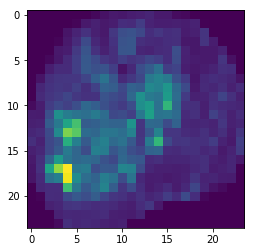

CNN预测图：


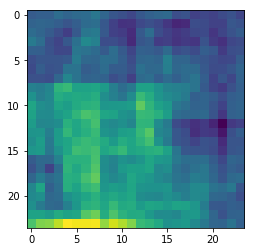

测试集第2个样本：金标准:


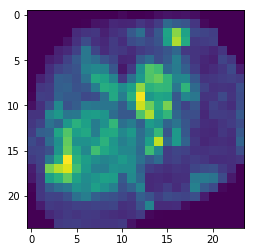

CNN预测图：


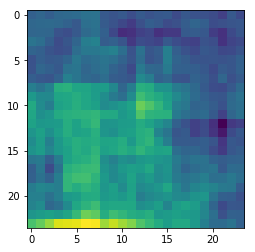

测试集第3个样本：金标准:


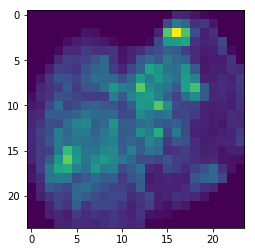

CNN预测图：


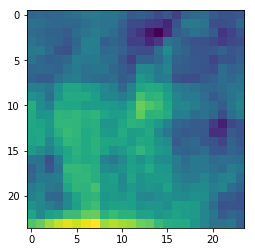

test:   10  mean_psnr:  24.915337  mean_ssim:  0.36958453  RMSE:  0.057769954
test:   20  mean_psnr:  29.608908  mean_ssim:  0.55709714  RMSE:  0.03366928
test:   30  mean_psnr:  31.723278  mean_ssim:  0.6310112  RMSE:  0.026768353
test:   40  mean_psnr:  32.291397  mean_ssim:  0.6597698  RMSE:  0.024978135
test:   50  mean_psnr:  32.680336  mean_ssim:  0.68261886  RMSE:  0.023906263
test:   60  mean_psnr:  33.060783  mean_ssim:  0.7020697  RMSE:  0.022820031
test:   70  mean_psnr:  33.5074  mean_ssim:  0.7282645  RMSE:  0.021715961
test:   80  mean_psnr:  34.171  mean_ssim:  0.7497899  RMSE:  0.02026201
test:   90  mean_psnr:  34.28818  mean_ssim:  0.7571632  RMSE:  0.020092707
test:   100  mean_psnr:  32.671814  mean_ssim:  0.74265164  RMSE:  0.023944924
test:   110  mean_psnr:  34.54577  mean_ssim:  0.77101654  RMSE:  0.019905804
test:   120  mean_psnr:  32.237385  mean_ssim:  0.742103  RMSE:  0.025353823
test:   130  mean_psnr:  34.917183  mean_ssim:  0.79317206  RMSE:  0.019013094

test:   1070  mean_psnr:  39.376408  mean_ssim:  0.9185557  RMSE:  0.011998637
test:   1080  mean_psnr:  39.43651  mean_ssim:  0.91709125  RMSE:  0.012077531
test:   1090  mean_psnr:  39.508064  mean_ssim:  0.91782737  RMSE:  0.011996611
test:   1100  mean_psnr:  39.394722  mean_ssim:  0.9191143  RMSE:  0.011935434
test:   1110  mean_psnr:  39.374245  mean_ssim:  0.91940314  RMSE:  0.012150241
test:   1120  mean_psnr:  38.95024  mean_ssim:  0.9138925  RMSE:  0.013004737
test:   1130  mean_psnr:  39.39611  mean_ssim:  0.9201151  RMSE:  0.012067426
test:   1140  mean_psnr:  39.13692  mean_ssim:  0.9154613  RMSE:  0.012505328
test:   1150  mean_psnr:  38.72697  mean_ssim:  0.9112586  RMSE:  0.012833221
test:   1160  mean_psnr:  39.252148  mean_ssim:  0.9184972  RMSE:  0.012138558
test:   1170  mean_psnr:  39.36421  mean_ssim:  0.9200807  RMSE:  0.012057754
test:   1180  mean_psnr:  39.618954  mean_ssim:  0.92041385  RMSE:  0.011901286
test:   1190  mean_psnr:  39.496998  mean_ssim:  0.919

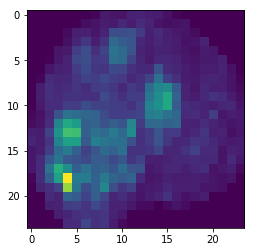

CNN预测图：


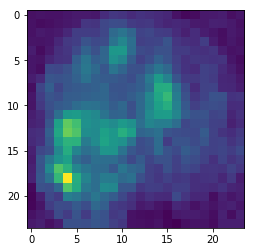

测试集第1个样本：金标准:


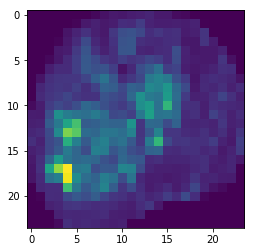

CNN预测图：


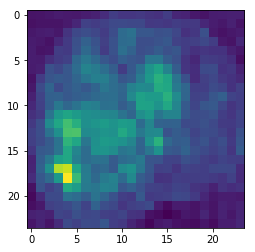

测试集第2个样本：金标准:


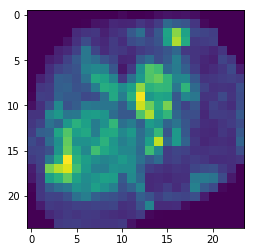

CNN预测图：


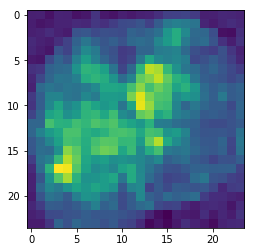

测试集第3个样本：金标准:


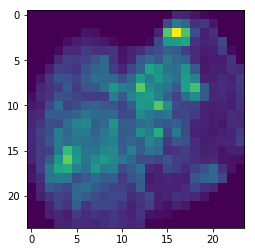

CNN预测图：


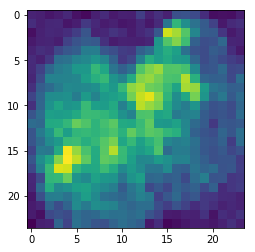

test:   2010  mean_psnr:  39.439243  mean_ssim:  0.9190312  RMSE:  0.011774234
test:   2020  mean_psnr:  39.12055  mean_ssim:  0.9160709  RMSE:  0.0136262765
test:   2030  mean_psnr:  38.856186  mean_ssim:  0.9204234  RMSE:  0.013419125
test:   2040  mean_psnr:  39.852478  mean_ssim:  0.92776245  RMSE:  0.011706903
test:   2050  mean_psnr:  40.198864  mean_ssim:  0.9319228  RMSE:  0.011093036
test:   2060  mean_psnr:  40.185497  mean_ssim:  0.93231875  RMSE:  0.011104422
test:   2070  mean_psnr:  40.35654  mean_ssim:  0.9335589  RMSE:  0.010880748
test:   2080  mean_psnr:  40.52366  mean_ssim:  0.93246675  RMSE:  0.011067459
test:   2090  mean_psnr:  40.52504  mean_ssim:  0.93055785  RMSE:  0.011311539
test:   2100  mean_psnr:  40.49909  mean_ssim:  0.9334974  RMSE:  0.011159572
test:   2110  mean_psnr:  39.902687  mean_ssim:  0.9177305  RMSE:  0.012384426
test:   2120  mean_psnr:  40.2824  mean_ssim:  0.93368804  RMSE:  0.010953897
test:   2130  mean_psnr:  40.04551  mean_ssim:  0.931

test:   3050  mean_psnr:  40.833252  mean_ssim:  0.9345755  RMSE:  0.011349916
test:   3060  mean_psnr:  40.648808  mean_ssim:  0.93222225  RMSE:  0.011502537
test:   3070  mean_psnr:  40.934647  mean_ssim:  0.93314934  RMSE:  0.011559291
test:   3080  mean_psnr:  40.35979  mean_ssim:  0.9373519  RMSE:  0.010785564
test:   3090  mean_psnr:  40.75198  mean_ssim:  0.9394119  RMSE:  0.0106479945
test:   3100  mean_psnr:  40.70788  mean_ssim:  0.9397692  RMSE:  0.010642241
test:   3110  mean_psnr:  40.429478  mean_ssim:  0.93807167  RMSE:  0.010892785
test:   3120  mean_psnr:  40.754616  mean_ssim:  0.94127727  RMSE:  0.010572329
test:   3130  mean_psnr:  40.462257  mean_ssim:  0.9382397  RMSE:  0.01080858
test:   3140  mean_psnr:  40.212418  mean_ssim:  0.9364449  RMSE:  0.011037056
test:   3150  mean_psnr:  40.58266  mean_ssim:  0.9397927  RMSE:  0.010787628
test:   3160  mean_psnr:  40.843174  mean_ssim:  0.93184733  RMSE:  0.011600628
test:   3170  mean_psnr:  40.80231  mean_ssim:  0.9

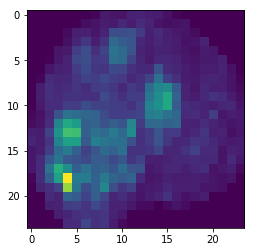

CNN预测图：


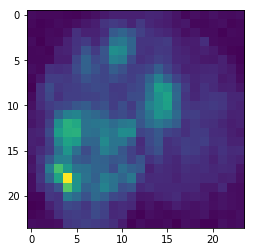

测试集第1个样本：金标准:


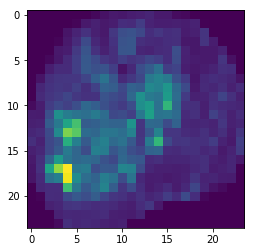

CNN预测图：


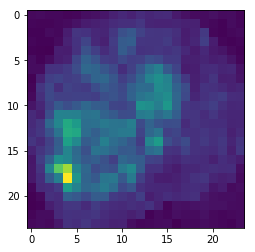

测试集第2个样本：金标准:


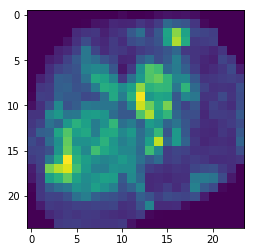

CNN预测图：


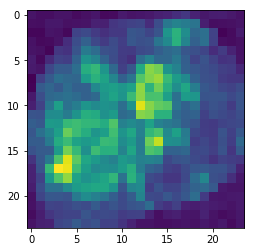

测试集第3个样本：金标准:


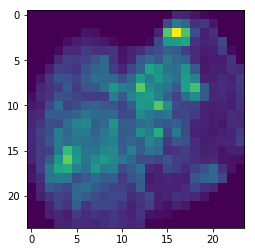

CNN预测图：


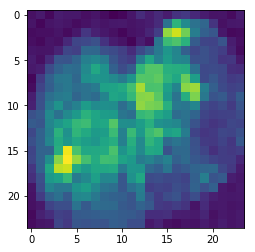

test:   4010  mean_psnr:  40.877  mean_ssim:  0.94415206  RMSE:  0.010422045
test:   4020  mean_psnr:  41.073536  mean_ssim:  0.9431793  RMSE:  0.010779042
test:   4030  mean_psnr:  40.867077  mean_ssim:  0.9439447  RMSE:  0.010553397
test:   4040  mean_psnr:  40.95105  mean_ssim:  0.943264  RMSE:  0.010565938
test:   4050  mean_psnr:  41.01604  mean_ssim:  0.9420507  RMSE:  0.010710998
test:   4060  mean_psnr:  40.80473  mean_ssim:  0.9443561  RMSE:  0.010458422
test:   4070  mean_psnr:  39.78917  mean_ssim:  0.93355244  RMSE:  0.011688795
test:   4080  mean_psnr:  41.25797  mean_ssim:  0.94438994  RMSE:  0.010485879
test:   4090  mean_psnr:  41.58003  mean_ssim:  0.94478244  RMSE:  0.010437506
test:   4100  mean_psnr:  39.162403  mean_ssim:  0.9301164  RMSE:  0.012012588
test:   4110  mean_psnr:  40.289745  mean_ssim:  0.93845445  RMSE:  0.010823829
test:   4120  mean_psnr:  40.421955  mean_ssim:  0.9189556  RMSE:  0.012582016
test:   4130  mean_psnr:  41.28968  mean_ssim:  0.9440086

test:   5050  mean_psnr:  38.825993  mean_ssim:  0.9061146  RMSE:  0.012665568
test:   5060  mean_psnr:  38.590153  mean_ssim:  0.9062529  RMSE:  0.013275551
test:   5070  mean_psnr:  39.31553  mean_ssim:  0.91009116  RMSE:  0.01226113
test:   5080  mean_psnr:  39.440453  mean_ssim:  0.9094735  RMSE:  0.012406499
test:   5090  mean_psnr:  39.399574  mean_ssim:  0.90726686  RMSE:  0.012640123
test:   5100  mean_psnr:  39.338264  mean_ssim:  0.9113601  RMSE:  0.012269644
test:   5110  mean_psnr:  39.197327  mean_ssim:  0.91285545  RMSE:  0.0124666635
test:   5120  mean_psnr:  38.924885  mean_ssim:  0.91107166  RMSE:  0.012746768
test:   5130  mean_psnr:  39.195988  mean_ssim:  0.9133943  RMSE:  0.012747991
test:   5140  mean_psnr:  38.977352  mean_ssim:  0.9132536  RMSE:  0.013052328
test:   5150  mean_psnr:  39.24422  mean_ssim:  0.9122088  RMSE:  0.012714972
test:   5160  mean_psnr:  39.50329  mean_ssim:  0.91539776  RMSE:  0.012310917
test:   5170  mean_psnr:  39.334553  mean_ssim:  0

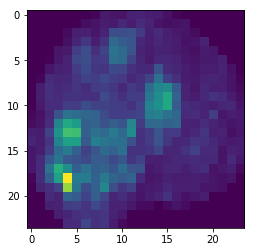

CNN预测图：


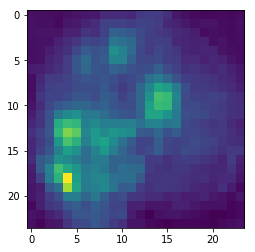

测试集第1个样本：金标准:


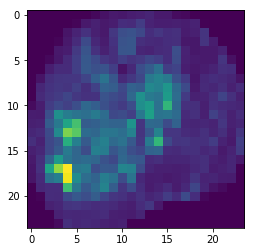

CNN预测图：


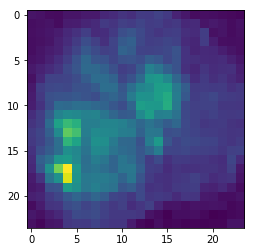

测试集第2个样本：金标准:


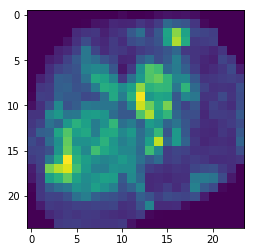

CNN预测图：


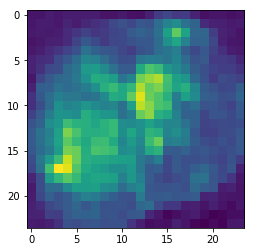

测试集第3个样本：金标准:


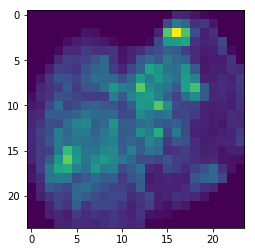

CNN预测图：


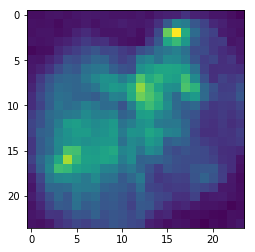

test:   6010  mean_psnr:  40.819767  mean_ssim:  0.93885523  RMSE:  0.010868545
test:   6020  mean_psnr:  40.632816  mean_ssim:  0.9389548  RMSE:  0.011023622
test:   6030  mean_psnr:  40.416847  mean_ssim:  0.9357201  RMSE:  0.011405808
test:   6040  mean_psnr:  40.719826  mean_ssim:  0.9412041  RMSE:  0.010636081
test:   6050  mean_psnr:  39.314907  mean_ssim:  0.92615104  RMSE:  0.012189061
test:   6060  mean_psnr:  39.530727  mean_ssim:  0.93038434  RMSE:  0.011650159
test:   6070  mean_psnr:  40.69058  mean_ssim:  0.9380226  RMSE:  0.011241437
test:   6080  mean_psnr:  40.687256  mean_ssim:  0.9332245  RMSE:  0.0117216
test:   6090  mean_psnr:  40.6646  mean_ssim:  0.94124347  RMSE:  0.010714704
test:   6100  mean_psnr:  40.12284  mean_ssim:  0.9357886  RMSE:  0.0112572
test:   6110  mean_psnr:  40.434715  mean_ssim:  0.9405106  RMSE:  0.011069016
test:   6120  mean_psnr:  40.44633  mean_ssim:  0.93806964  RMSE:  0.011191583
test:   6130  mean_psnr:  40.689743  mean_ssim:  0.94104

test:   7050  mean_psnr:  41.25344  mean_ssim:  0.94815266  RMSE:  0.010286723
test:   7060  mean_psnr:  41.166065  mean_ssim:  0.9458458  RMSE:  0.010586522
test:   7070  mean_psnr:  39.728313  mean_ssim:  0.933485  RMSE:  0.012221706
test:   7080  mean_psnr:  38.90459  mean_ssim:  0.92354983  RMSE:  0.013441269
test:   7090  mean_psnr:  40.206287  mean_ssim:  0.93786687  RMSE:  0.011515346
test:   7100  mean_psnr:  40.75257  mean_ssim:  0.94468176  RMSE:  0.010781059
test:   7110  mean_psnr:  41.074295  mean_ssim:  0.9466825  RMSE:  0.010399967
test:   7120  mean_psnr:  40.836002  mean_ssim:  0.9451949  RMSE:  0.01064145
test:   7130  mean_psnr:  40.720623  mean_ssim:  0.94437724  RMSE:  0.010855899
test:   7140  mean_psnr:  41.12168  mean_ssim:  0.9465873  RMSE:  0.010540428
test:   7150  mean_psnr:  41.256554  mean_ssim:  0.9487251  RMSE:  0.010259227
test:   7160  mean_psnr:  40.948624  mean_ssim:  0.946199  RMSE:  0.010692083
test:   7170  mean_psnr:  40.33864  mean_ssim:  0.9413

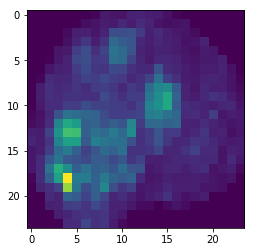

CNN预测图：


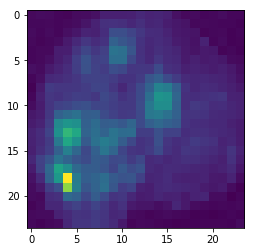

测试集第1个样本：金标准:


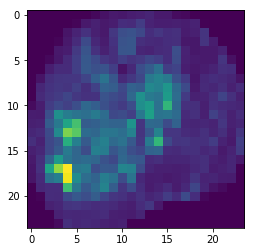

CNN预测图：


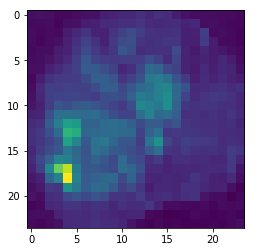

测试集第2个样本：金标准:


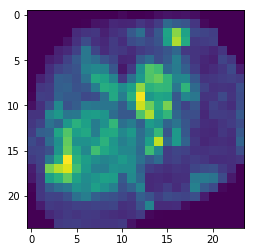

CNN预测图：


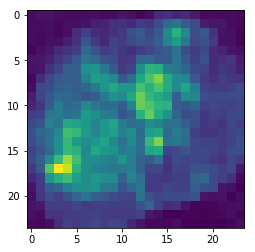

测试集第3个样本：金标准:


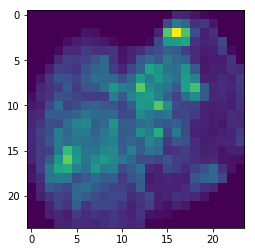

CNN预测图：


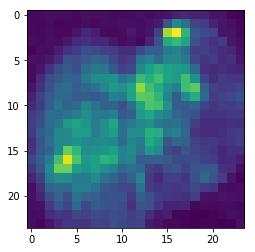

test:   8010  mean_psnr:  41.40255  mean_ssim:  0.9462528  RMSE:  0.010694525
test:   8020  mean_psnr:  41.031227  mean_ssim:  0.9452953  RMSE:  0.010737691
test:   8030  mean_psnr:  41.65001  mean_ssim:  0.9480485  RMSE:  0.010417822
test:   8040  mean_psnr:  41.39831  mean_ssim:  0.94673675  RMSE:  0.010642639
test:   8050  mean_psnr:  41.180073  mean_ssim:  0.94826466  RMSE:  0.010460511
test:   8060  mean_psnr:  41.51905  mean_ssim:  0.9494088  RMSE:  0.010370966
test:   8070  mean_psnr:  41.39659  mean_ssim:  0.9492761  RMSE:  0.010432838
test:   8080  mean_psnr:  41.519794  mean_ssim:  0.9450466  RMSE:  0.010809424
test:   8090  mean_psnr:  41.344467  mean_ssim:  0.9494724  RMSE:  0.010466456
test:   8100  mean_psnr:  41.263382  mean_ssim:  0.9478308  RMSE:  0.0105753215
test:   8110  mean_psnr:  41.478306  mean_ssim:  0.94905406  RMSE:  0.010395755
test:   8120  mean_psnr:  41.589096  mean_ssim:  0.9501213  RMSE:  0.010266162
test:   8130  mean_psnr:  41.256283  mean_ssim:  0.94

test:   9050  mean_psnr:  41.620228  mean_ssim:  0.95018107  RMSE:  0.010391277
test:   9060  mean_psnr:  41.693  mean_ssim:  0.9512196  RMSE:  0.010233864
test:   9070  mean_psnr:  41.68467  mean_ssim:  0.9514102  RMSE:  0.010258146
test:   9080  mean_psnr:  41.69081  mean_ssim:  0.9491503  RMSE:  0.010422299
test:   9090  mean_psnr:  41.587997  mean_ssim:  0.9480429  RMSE:  0.010548658
test:   9100  mean_psnr:  41.689453  mean_ssim:  0.94838876  RMSE:  0.010483784
test:   9110  mean_psnr:  41.53221  mean_ssim:  0.94865936  RMSE:  0.010438309
test:   9120  mean_psnr:  41.671543  mean_ssim:  0.9442861  RMSE:  0.010910783
test:   9130  mean_psnr:  41.687077  mean_ssim:  0.9492323  RMSE:  0.010409413
test:   9140  mean_psnr:  41.72894  mean_ssim:  0.94939905  RMSE:  0.010374823
test:   9150  mean_psnr:  41.581608  mean_ssim:  0.95040494  RMSE:  0.010414655
test:   9160  mean_psnr:  41.259945  mean_ssim:  0.9452995  RMSE:  0.010925732
test:   9170  mean_psnr:  41.498196  mean_ssim:  0.950

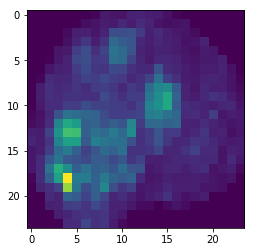

CNN预测图：


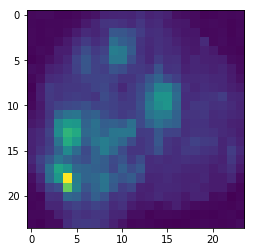

测试集第1个样本：金标准:


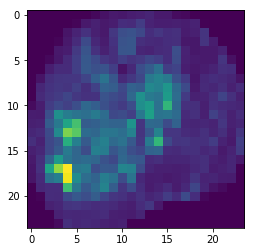

CNN预测图：


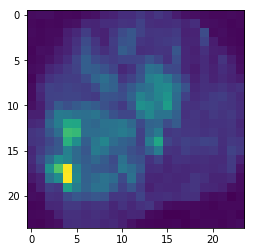

测试集第2个样本：金标准:


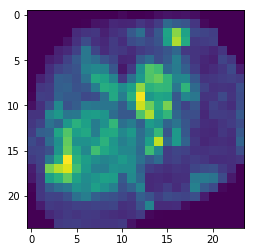

CNN预测图：


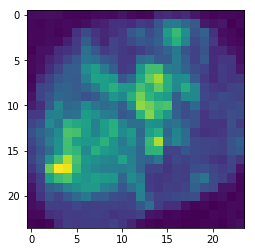

测试集第3个样本：金标准:


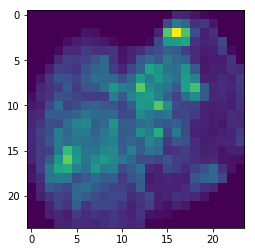

CNN预测图：


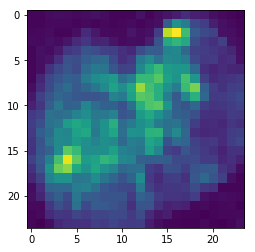

In [6]:
with tf.Session() as sess:
    init_op = tf.initialize_all_variables()
    init = tf.global_variables_initializer()
    sess.run([init_op,init])
    
    for epoch in range(10001):
        idx = np.random.randint(0,len(x_train),64)
        x_,y_ = x_train[idx],y_train[idx]
        _ = sess.run([train_step],feed_dict={x:x_,y:y_})
        
        if epoch % 10 == 0:
            LOSS, Mean_ssim, Mean_psnr, RMSE = sess.run([loss, mean_ssim, mean_psnr, rmse],feed_dict={x: x_test, y: y_test})
            print("test:  ", str(epoch), " mean_psnr: ", Mean_psnr, " mean_ssim: ", Mean_ssim, " RMSE: ", RMSE)

        if epoch % 2000 == 0:
            ktrans_pred = sess.run(prediction,feed_dict={x:x_test,y:y_test})
            for i in range(4):
                print("测试集第"+str(i)+"个样本：金标准:")
                plt.imshow(y_test[i,:,:,0])
                plt.show()
                print("CNN预测图：")
                plt.imshow(ktrans_pred[i,:,:,0])
                plt.show()
